In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

In [497]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 2
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)
cluster_allocs_recorded = []
uniq_vals_out = []
covs_recorded = []
mus_recorded = []

In [555]:
def run_one_gibbs(data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov):
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            mus[h],covs[h], acc_rate = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
        else:
            mus[h],covs[h], acc_rate = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov)

    #print("mus" + str(mus))
    #print("covs" + str(covs))
    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    #print("weights" + str(weights))
    
    cluster_allocs = update_cluster_allocs(data, weights, mus,covs)
    #print("Cluster allocs" + str(cluster_allocs))
    
    #Save the values so that if we stop the kernel we have a visual output 
    global cluster_allocs_recorded
    cluster_allocs_recorded = cluster_allocs

    global mus_recorded
    mus_recorded = mus
    
    global covs_recorded
    covs_recorded = covs
    
    return cluster_allocs, mus,covs, weights, acc_rate

def run_mcmc(data, k , niter=1000, nburn=300, thin=5 ): 
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    #Bijector setup
    tfb = tfp.bijectors
    bij = tfb.Chain([
            tfb.TransformDiagonal(tfb.Softplus()),
            tfb.FillTriangular()])

    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    mus = np.array(tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k))
    covs = np.array(tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k))
    

    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    cov_prop_cov = 0.1 * np.eye(3)
    cov_prop_mu = 0.5 * np.eye(2)
    
    #Output values
    allocs_out = []
    mus_out = []
    covs_out = []
    weights_out = []
    acc_rates = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, mus,covs, weights, acc_rate = run_one_gibbs(
            data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov)
        acc_rates.append(acc_rate)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            mus_out.append(mus.copy())
            covs_out.append(covs.copy())
            weights_out.append(weights)
            
        if i % 10 == 0 and i > 11:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            print("Acceptance rate: " + str(np.mean(acc_rates[-10:])))
            
    return allocs_out, mus_out,covs_out, weights_out,acc_rates

In [583]:
def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    #Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return mu_old,cov_old,accept_rate

    else:
        return mu,cov,accept_rate
    
def sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    # Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return np.array(mu_old),np.array(cov_old),accept_rate

    else:
        return np.array(mu),np.array(cov),accept_rate
    

def sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector):
    """
    Sample new mean and covariance matrix through the bijection
    """
    mu = tfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample()
    
    chol = np.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = tfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample()
    cov_sampl = bijector.forward(vec_sampl)
    cov = np.matmul(cov_sampl , np.transpose(cov_sampl))
    log_jac = abs(bijector.forward_log_det_jacobian(vec_sampl))
    
    return mu,cov,log_jac

def compute_beta_NW_log(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
    
    mu_0 = np.zeros(2)
    cov_0 = np.eye(2)
    nu_0 = 3
    phi_0 = nu_0*np.eye(2)
    
    # NW distribution terms
    num_0 = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den_0 = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Data distribution terms
    num_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu, cov).log_prob(clusdata))
    den_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu_old, cov_old).log_prob(clusdata))
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

#     print("num0:")
#     print(num_0)
#     print("den0:")
#     print(den_0)
#     print("num1:")
#     print(num_1)
#     print("den1:")
#     print(den_1)
#     print("sum_")
#     print(sum_)
#     print("mu_old")
#     print(mu_old)
#     print("mu")
#     print(mu)
    return num_0 + num_1  - den_0 - den_1 + sum_ + jac_term

def compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"n
    """
    
    mu_0 = np.zeros(2)
    cov_0 = np.eye(2)
    nu_0 = 3
    phi_0 = np.eye(2)/nu_0
    
    # NW distribution terms
    num = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))
#     print("num" + str(num))   
#     print("den" + str(den))   
#     print("jac" + str(jac_term)) 
#     print("mu_old" + str(mu_old))
#     print("mu" + str(mu))
#     print("sum" + str(sum_))
    return num  - den + sum_ + jac_term
  
def evaluate_NW_log(x_mu, x_cov, mu_n, cov_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, cov_n, phi_n, nu_n ) ]
    L = Normal x Inverse Wishart
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, cov_n).log_prob(x_mu)
    
    return f1 + f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case, already taking consideration of g() to bound Wasserstein term
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    # Function g
    if(norm + trace < 1):
        return norm + trace
    else:
        return 1

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, mus, covs):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(mus, covs).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    return tfd.Categorical(probs=probs, validate_args=True).sample()

In [557]:
#RUNNING THE MCMC
start = time.time()
allocs_out, mus_out,covs_out, weights_out,accept_rate_out = run_mcmc(data, k , niter = 300,nburn = 0,thin = 1)
end = time.time()
print("Total time: " + str(end-start))

/Users/leopere/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/internal/backend/numpy/numpy_math.py:659: RuntimeWarning: divide by zero encountered in log
  lambda x, name=None: np.log(_convert_to_tensor(x)))


Iter 21 / 300 Remaining minutes: 4.3 Acceptance rate: 0.08163361823650161
Iter 31 / 300 Remaining minutes: 1.7 Acceptance rate: 0.09161424503154356
Iter 41 / 300 Remaining minutes: 1.7 Acceptance rate: 0.07640198061458961
Iter 51 / 300 Remaining minutes: 1.6 Acceptance rate: 0.07174201015219976
Iter 61 / 300 Remaining minutes: 1.6 Acceptance rate: 0.07024240563200343
Iter 71 / 300 Remaining minutes: 1.6 Acceptance rate: 0.045363606109939676
Iter 81 / 300 Remaining minutes: 1.4 Acceptance rate: 0.06916534510442496
Iter 91 / 300 Remaining minutes: 1.3 Acceptance rate: 0.07573229549075874
Iter 101 / 300 Remaining minutes: 1.3 Acceptance rate: 0.05601306312205927
Iter 111 / 300 Remaining minutes: 1.2 Acceptance rate: 0.07081937746116485
Iter 121 / 300 Remaining minutes: 1.1 Acceptance rate: 0.07428383822782106
Iter 131 / 300 Remaining minutes: 1.1 Acceptance rate: 0.06956470154248567
Iter 141 / 300 Remaining minutes: 1.0 Acceptance rate: 0.06643252462466784
Iter 151 / 300 Remaining minutes

# Traceplots

0    1000
dtype: int64


<BarContainer object of 1 artists>

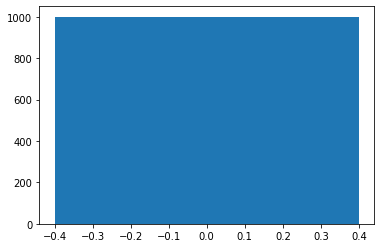

In [558]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(cluster_allocs_recorded).value_counts())
x, y = np.unique(cluster_allocs_recorded, return_counts=True)
plt.bar(x, y)

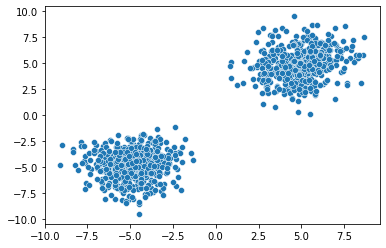

In [559]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[cluster_allocs_recorded == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

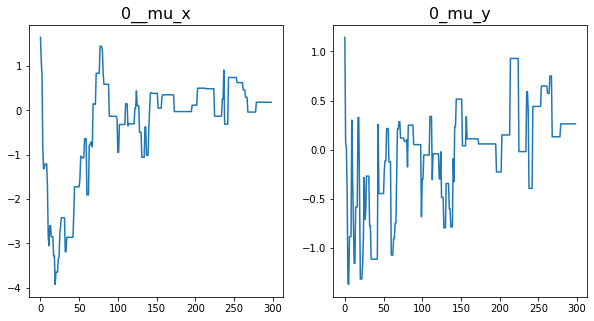

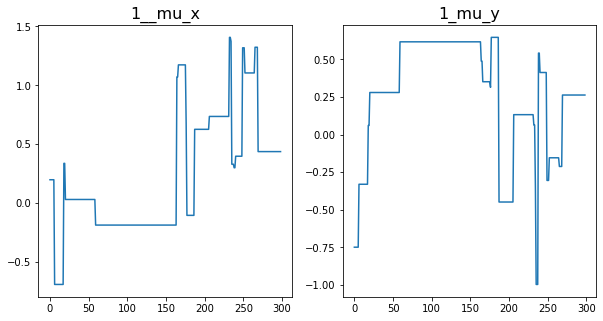

In [560]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [mu[i][0] for mu in mus_out]
    second_comp = [mu[i][1] for mu in mus_out]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__mu_x", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_mu_y", fontsize=16)

    plt.show()

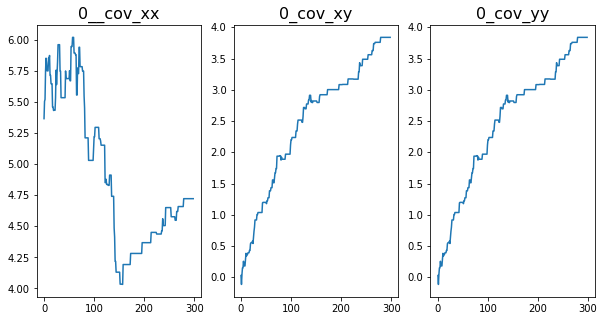

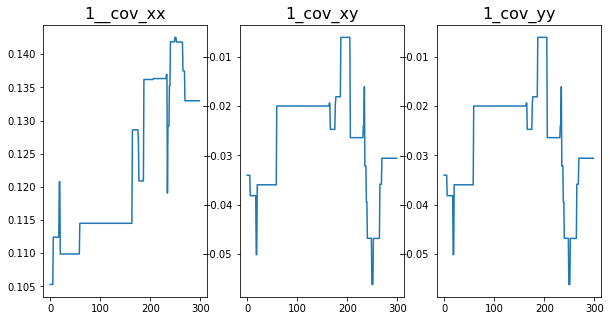

In [561]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [covs[i][0,0] for covs in covs_out]
    second_comp = [covs[i][0,1] for covs in covs_out]
    third_comp = [covs[i][1,1] for covs in covs_out]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__cov_xx", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_cov_xy", fontsize=16)
    
    axes[2].plot(np.arange(len(third_comp)), second_comp,)
    axes[2].set_title(str(i) + "_cov_yy", fontsize=16)

    plt.show()

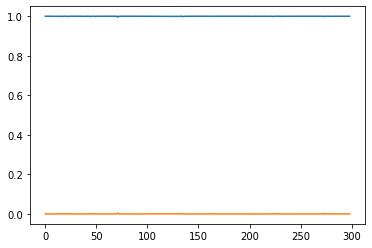

In [562]:
for i in range(k):
    weights = [w[i] for w in weights_out]
    plt.plot(np.arange(len(weights)) , weights)
    

# Check Metropolis Hastings Traceplots to fullconditional

In [584]:
mus = np.array([ [0.5,0.5],[-0.5,-0.5] ])
covs = np.array([ np.eye(2) , np.eye(2)] )
cov_prop_mu = 0.05 * np.eye(2)
cov_prop_cov = 0.0001 * np.eye(3)
h = 0
mu_MH = []
cov_MH = []
y = np.array( [datum for datum in data if datum[0] > 0] )
for i in range(1500):
    mus[h],covs[h], acc_rate = sample_uniq_vals_fullcond_Wasserstein_NW_log(y,mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
    print("Acc_rate : " + str(acc_rate))
    mu_MH.append(mus[h].copy())
    cov_MH.append(covs[h].copy())

Acc_rate : 1.1096412256433032e-98
Acc_rate : 2.1235711155151e-272
Acc_rate : 0.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.0
Acc_rate : 1.0
Acc_rate : 3.0512286193438594e-115
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.3866781867763714e-92
Acc_rate : 2.814323503228486e-43
Acc_rate : 2.4523753970208907e-71
Acc_rate : 1.0
Acc_rate : 6.434199009972231e-23
Acc_rate : 3.049349582414915e-73
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 7.551388297591419e-149
Acc_rate : 1.0
Acc_rate : 0.00022173235336493533
Acc_rate : 1.0
Acc_rate : 2.2532095759340354e-208
Acc_rate : 3.0279197408387634e-238
Acc_rate : 1.0
Acc_rate : 8.729195902492805e-07
Acc_rate : 5.859387379453603e-119
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.0
Acc_rate : 1.1488598420399424e-57
Acc_rate : 1.0
Acc_rate : 1.2057386548950963e-51
Acc_rate : 1.0
Acc_rate : 1.2201297547534019e-23
Acc_rate : 1.0
Acc_rate : 8.076214187750088e-307
Acc_rate : 1.0
Acc_rate : 1.751472693321243e-117
Acc_rate : 0.0
Acc_rate : 1.0
Acc_rate : 2.55263970948655

Acc_rate : 4.801349334953023e-10
Acc_rate : 0.00013507447359230424
Acc_rate : 1.0
Acc_rate : 0.037640400847088876
Acc_rate : 1.0
Acc_rate : 7.341614543690808e-05
Acc_rate : 0.7219788951460608
Acc_rate : 6.695427796666732e-10
Acc_rate : 3.9161548427346875e-28
Acc_rate : 3.9527506523628366e-11
Acc_rate : 2.2275487531545073e-06
Acc_rate : 1.3446310770365915e-20
Acc_rate : 5.5539461984740005e-05
Acc_rate : 2.4277094688533725e-14
Acc_rate : 0.04037330432211377
Acc_rate : 2.320510678148926e-27
Acc_rate : 0.0029539941730756447
Acc_rate : 0.0002299635330284277
Acc_rate : 8.050963983988691e-29
Acc_rate : 0.08836184610939087
Acc_rate : 2.846276948102349e-33
Acc_rate : 0.00032382146275433606
Acc_rate : 0.18051143155782515
Acc_rate : 2.5896118660860796e-15
Acc_rate : 0.0011427808842490374
Acc_rate : 2.2211138465441736e-19
Acc_rate : 2.605698142790162e-05
Acc_rate : 1.89928189884293e-05
Acc_rate : 8.892844163164292e-07
Acc_rate : 9.265747002164268e-20
Acc_rate : 1.0
Acc_rate : 9.510515103531293e-09

Acc_rate : 4.1785404133924324e-05
Acc_rate : 0.040591704373237135
Acc_rate : 1.605818225067054e-06
Acc_rate : 1.0
Acc_rate : 9.472859292106434e-24
Acc_rate : 0.3280400065244575
Acc_rate : 0.023684471693378114
Acc_rate : 0.001624781751699212
Acc_rate : 0.0003993176068062564
Acc_rate : 4.507500146131669e-05
Acc_rate : 1.459396656441879e-16
Acc_rate : 7.329570400114136e-11
Acc_rate : 1.8745057616022796e-09
Acc_rate : 1.2358492289979143e-13
Acc_rate : 3.5050035377993644e-06
Acc_rate : 5.58959054018713e-13
Acc_rate : 0.0030182887790793085
Acc_rate : 1.4281579587615344e-09
Acc_rate : 0.002646412078658861
Acc_rate : 4.151808831759468e-12
Acc_rate : 1.0
Acc_rate : 2.3593619620108738e-17
Acc_rate : 0.00037678957211066796
Acc_rate : 0.00010142528943120039
Acc_rate : 2.3205000806908707e-09
Acc_rate : 5.395163818030741e-08
Acc_rate : 4.884399005973567e-16
Acc_rate : 1.339951776542005e-31
Acc_rate : 2.0255557955652677e-05
Acc_rate : 0.000545749450071438
Acc_rate : 0.00015847596368463908
Acc_rate : 

Acc_rate : 1.6593021126292874e-12
Acc_rate : 0.15306330122839135
Acc_rate : 1.0
Acc_rate : 0.913047256535639
Acc_rate : 0.01762657731396764
Acc_rate : 5.317595664851594e-07
Acc_rate : 0.5630355257728087
Acc_rate : 1.126521337250677e-16
Acc_rate : 1.7162983728392966e-06
Acc_rate : 0.013949573924303954
Acc_rate : 0.3957921793479532
Acc_rate : 1.0
Acc_rate : 0.031356355668942515
Acc_rate : 0.09027991715614966
Acc_rate : 2.2195563593355843e-05
Acc_rate : 0.23526896294585922
Acc_rate : 0.00048431219641174
Acc_rate : 0.0003124331191205587
Acc_rate : 3.340463612615044e-18
Acc_rate : 1.2600586234742394e-28
Acc_rate : 1.0980358409449582e-21
Acc_rate : 0.00031823621718484997
Acc_rate : 0.0002747162618364555
Acc_rate : 1.0
Acc_rate : 6.68741530557753e-13
Acc_rate : 3.106400322904899e-13
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 2.91526175413322e-17
Acc_rate : 1.7243315803112443e-06
Acc_rate : 0.029074874734747066
Acc_rate : 1.0
Acc_rate : 4.165103092086034e-11
Acc_rate : 5.685473107177948e-28
Acc_

Acc_rate : 0.025483071436091378
Acc_rate : 9.226065488157389e-07
Acc_rate : 0.7866274132812636
Acc_rate : 3.296206506618444e-08
Acc_rate : 5.292078608429804e-10
Acc_rate : 2.867643488612252e-11
Acc_rate : 0.19649387944721836
Acc_rate : 0.24337092318722756
Acc_rate : 1.7671777247469935e-16
Acc_rate : 5.986008043203783e-19
Acc_rate : 0.0057711630832130364
Acc_rate : 0.00025469668580966736
Acc_rate : 0.5422739715022502
Acc_rate : 2.241325937139598e-05
Acc_rate : 2.8617583681090807e-07
Acc_rate : 1.2981298139526484e-23
Acc_rate : 0.4591830969775925
Acc_rate : 1.0
Acc_rate : 0.0012967857023441919
Acc_rate : 0.0013481939908604938
Acc_rate : 0.18029392870442823
Acc_rate : 9.050143125614202e-11
Acc_rate : 2.4230956657459583e-05
Acc_rate : 0.0087226942028238
Acc_rate : 0.02010690494321126
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.0007164854316994
Acc_rate : 1.125308334751649e-19
Acc_rate : 4.034090811405273e-09
Acc_rate : 0.0020418777687286793
Acc_rate : 0.001099789025554824
Acc_rate : 0.00401

Acc_rate : 0.025861637311025126
Acc_rate : 1.0137333248066554e-07
Acc_rate : 4.831249041068575e-21
Acc_rate : 0.22830794635233265
Acc_rate : 5.547879077878879e-06
Acc_rate : 2.428838663210479e-06
Acc_rate : 0.010413284182582496
Acc_rate : 1.0
Acc_rate : 3.5373088885872877e-16
Acc_rate : 0.006427415337467162
Acc_rate : 4.26229591399691e-15
Acc_rate : 0.04428049153865229
Acc_rate : 1.897786918407177e-12
Acc_rate : 0.021464668373539726
Acc_rate : 0.1341099604452661
Acc_rate : 1.9642530352364247e-06
Acc_rate : 0.00298079948306296
Acc_rate : 0.08044489504066514
Acc_rate : 0.00046182653839445156
Acc_rate : 0.05091711862074519
Acc_rate : 0.08297705150534959
Acc_rate : 0.13712217701555385
Acc_rate : 0.01844262948991641
Acc_rate : 3.510381689205308e-06
Acc_rate : 0.2109688471844711
Acc_rate : 1.7993498022206436e-09
Acc_rate : 0.02343271553758426
Acc_rate : 0.35752510406729476
Acc_rate : 0.47854675342775127
Acc_rate : 6.804466945708326e-10
Acc_rate : 1.3582635149812101e-06
Acc_rate : 6.664726490

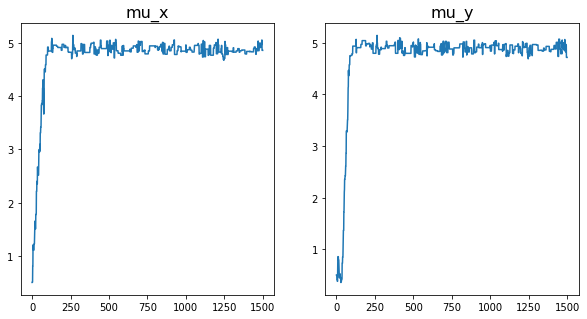

In [585]:

#Get mean of the first gaussian component
first_comp = [mu[0] for mu in mu_MH]
second_comp = [mu[1] for mu in mu_MH]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("mu_x", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("mu_y", fontsize=16)

plt.show()

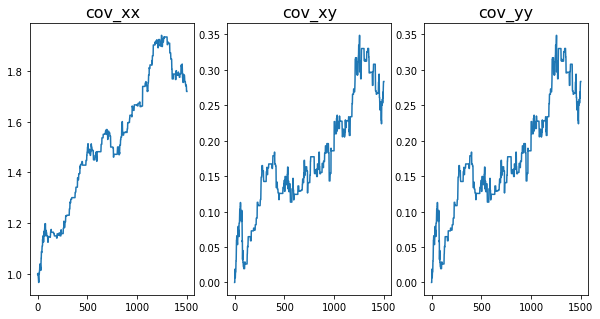

In [586]:
#Get mean of the first gaussian component
first_comp = [covs[0,0] for covs in cov_MH]
second_comp = [covs[0,1] for covs in cov_MH]
third_comp = [covs[1,1] for covs in cov_MH]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("cov_xx", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("cov_xy", fontsize=16)

axes[2].plot(np.arange(len(third_comp)), second_comp,)
axes[2].set_title("cov_yy", fontsize=16)

plt.show()

# Checking MH convergence to prior

In [575]:
mus = np.array([ [0.5,0.5],[-0.5,-0.5] ])
covs = np.array([ np.eye(2) , np.eye(2)] )
cov_prop_mu = 0.5 * np.eye(2)
cov_prop_cov = 0.001 * np.eye(3)
h = 0
mu_MH = []
cov_MH = []
y = np.array( [datum for datum in data if datum[0] > 0] )
for i in range(1500):
    mus[h],covs[h], acc_rate = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
    print("Acc_rate : " + str(acc_rate))
    mu_MH.append(mus[h].copy())
    cov_MH.append(covs[h].copy())

Acc_rate : 0.7815024444357015
Acc_rate : 0.15057854264559384
Acc_rate : 0.9851691611179811
Acc_rate : 0.2581353792567432
Acc_rate : 1.0
Acc_rate : 0.7255375709599284
Acc_rate : 0.4670645739311092
Acc_rate : 0.009072643216998633
Acc_rate : 0.8657328696685311
Acc_rate : 0.9426202590793011
Acc_rate : 1.0
Acc_rate : 0.760267275215406
Acc_rate : 1.0
Acc_rate : 0.697236514370478
Acc_rate : 0.8491549181118251
Acc_rate : 0.2841701772320325
Acc_rate : 0.3691808173332699
Acc_rate : 0.8828408997058607
Acc_rate : 1.0
Acc_rate : 0.04524803103221843
Acc_rate : 0.3695554438552315
Acc_rate : 0.00735090311368561
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.045724484022964654
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8180391050352198
Acc_rate : 0.44457100067077576
Acc_rate : 0.7230861258177805
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.907002180318971
Acc_rate : 1.0
Acc_rate : 0.7748385187610767
Acc_rate : 0.7176665797069648
Acc_rate : 1.0
Acc_rate : 1.0
Acc_r

Acc_rate : 1.0
Acc_rate : 0.6292129062938507
Acc_rate : 0.14107216177188556
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.6646495091738627
Acc_rate : 0.9302754081034935
Acc_rate : 0.04554794282687034
Acc_rate : 0.35418673311092647
Acc_rate : 0.24982277862354557
Acc_rate : 1.0
Acc_rate : 0.7664157929195409
Acc_rate : 0.33531678610939886
Acc_rate : 0.39748101178037915
Acc_rate : 0.08584457167223636
Acc_rate : 1.0
Acc_rate : 0.6360930842986314
Acc_rate : 1.0
Acc_rate : 0.7111007342266507
Acc_rate : 1.0
Acc_rate : 0.5006194149998332
Acc_rate : 0.5336008750234307
Acc_rate : 1.0
Acc_rate : 0.24049370922593297
Acc_rate : 0.017098896269309875
Acc_rate : 1.0
Acc_rate : 0.41047997789571605
Acc_rate : 0.16606612549672947
Acc_rate : 0.2811671526125609
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8424468914691652
Acc_rate : 0.8072043951909218
Acc_rate : 0.17968635695493518
Acc_rate : 0.3446476241278521
Acc_rate : 0.29606803836132267
Acc_rate : 0.4465736808539685
Acc_rate : 1.0
Acc_rate : 

Acc_rate : 0.011839360803252277
Acc_rate : 1.0
Acc_rate : 0.46538920171090276
Acc_rate : 0.20012756302895962
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.7817560955596392
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.7502435142419377
Acc_rate : 1.0
Acc_rate : 0.16694259603226938
Acc_rate : 1.0
Acc_rate : 0.9840557349389242
Acc_rate : 0.35716080297649366
Acc_rate : 0.3405533807839125
Acc_rate : 0.3207142663232787
Acc_rate : 0.027687181719066225
Acc_rate : 0.15208579466633512
Acc_rate : 1.0
Acc_rate : 0.1215283246512186
Acc_rate : 0.3336974607378118
Acc_rate : 0.09971057912882818
Acc_rate : 1.0
Acc_rate : 0.4680916572970408
Acc_rate : 1.0
Acc_rate : 0.6969274912263215
Acc_rate : 0.18909601902933273
Acc_rate : 0.21176884170261792
Acc_rate : 0.4040872059631623
Acc_rate : 0.1827090525472856
Acc_rate : 1.0
Acc_rate : 0.08686412100373475
Acc_rate : 0.08956662559193156
Acc_rate : 0.863670547530442
Acc_rate : 0.011889500226280988
Acc_rate : 1.0
Acc_rate : 0.190890111271

Acc_rate : 0.8408666369570648
Acc_rate : 1.0
Acc_rate : 0.018222105620006368
Acc_rate : 0.7884059173800834
Acc_rate : 0.23499762683177816
Acc_rate : 0.8771583617450417
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8765957207602249
Acc_rate : 0.4617685551869577
Acc_rate : 0.5788383184772741
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.22981198050548327
Acc_rate : 0.24194104979725067
Acc_rate : 0.46999044407387364
Acc_rate : 0.6415504049653278
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.7733502203050528
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.5586507100213568
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.3082761097703277
Acc_rate : 0.02409975726722621
Acc_rate : 0.1337729996551397
Acc_rate : 0.5261550570911208
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.15500273976780843
Acc_rate : 1.0
Acc_rate : 0.5816772054790751
Acc_rate : 1.0
Ac

Acc_rate : 5.485696620532648e-05
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.041008937940214714
Acc_rate : 0.8631227681145883
Acc_rate : 0.43845333650328266
Acc_rate : 0.05616725328844971
Acc_rate : 0.03799362572506778
Acc_rate : 1.0
Acc_rate : 0.0322176167250557
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.5493851161150133
Acc_rate : 0.17821518936266809
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8356533143755456
Acc_rate : 1.0
Acc_rate : 0.15617562712755462
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.79185737048198
Acc_rate : 0.18021773448657388
Acc_rate : 0.14249484365191076
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.011033488330613381
Acc_rate : 0.2812394008835152
Acc_rate : 0.08118378640023317
Acc_rate : 0.38607299731959327
Acc_rate : 0.02512358065890562
Acc_rate : 0.027226146869774218
Acc_rate : 1.0
Acc_rate : 0.8532461666716661
Acc_rate : 0.1934249209076006
Acc_rate : 1.0
Acc_rate : 0.7857905383

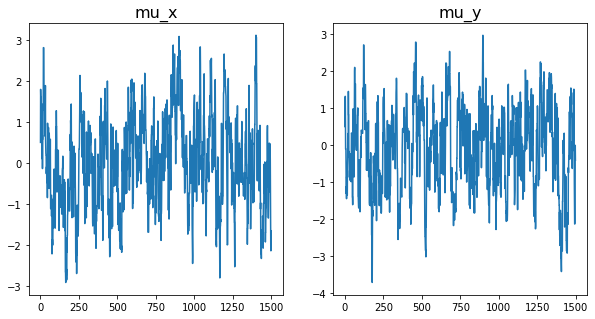

In [579]:
#Get mean of the first gaussian component
first_comp = [mu[0] for mu in mu_MH]
second_comp = [mu[1] for mu in mu_MH]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("mu_x", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("mu_y", fontsize=16)

plt.show()

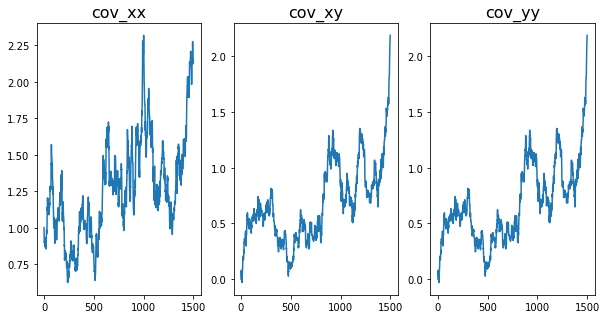

In [580]:
#Get mean of the first gaussian component
first_comp = [covs[0,0] for covs in cov_MH]
second_comp = [covs[0,1] for covs in cov_MH]
third_comp = [covs[1,1] for covs in cov_MH]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("cov_xx", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("cov_xy", fontsize=16)

axes[2].plot(np.arange(len(third_comp)), second_comp,)
axes[2].set_title("cov_yy", fontsize=16)

plt.show()